In [1]:
!pip install scikeras

In [2]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, History
from scikeras.wrappers import KerasClassifier
from google.colab import drive
import time
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import tensorflow.keras.backend as K
from sklearn.manifold import TSNE
import tensorflow as tf
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
test_size = 0.1
epochs = 50
batch_size = 32
learning_rate = 0.0001
validation_split = 0.1
patience = 5

encoding_dim = 10

tsne = 'no'

model_arch = 'simple' # simple or complex
if model_arch == 'complex':
    first_layer_neurons = 256 # complex
else:
    first_layer_neurons = 64 # simple

In [7]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    f1 = 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))
    return f1

# metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tfa.metrics.F1Score(num_classes=3, average='macro')]
metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]

In [8]:
def build_autoencoder_model(input_dim, encoding_dim):
  # Build the autoencoder model
  autoencoder = Sequential()

  # Encoder
  autoencoder.add(Dense(128, activation='relu', input_shape=(input_dim,)))
  autoencoder.add(Dense(64, activation='relu'))
  autoencoder.add(Dense(encoding_dim, activation='relu'))  # Bottleneck layer

  # Decoder
  autoencoder.add(Dense(64, activation='relu'))
  autoencoder.add(Dense(128, activation='relu'))
  autoencoder.add(Dense(input_dim, activation='sigmoid'))  # Reconstruct original input dimensions

  return autoencoder


def build_NN_model(input_dim, output_units):
  if model_arch == 'complex':
      print("\n Building complex model")
      model = Sequential()
      model.add(Dense(first_layer_neurons, input_dim=input_dim, activation='relu'))
      model.add(Dropout(0.2))

      model.add(Dense(128, activation='relu'))
      model.add(Dropout(0.2))

      model.add(Dense(64, activation='relu'))
      # model.add(Dropout(0.2))

      model.add(Dense(32, activation='relu'))
      # model.add(Dropout(dropout_rate))

      model.add(Dense(16, activation='relu'))
      # model.add(Dropout(dropout_rate))

      model.add(Dense(output_units, activation='softmax'))  # Final output layer
      return model

  if model_arch == 'simple':
      print("\n Building simple model")
      model = Sequential()
      model.add(Dense(first_layer_neurons, input_dim=input_dim, activation='relu'))
      model.add(Dropout(0.2))

      model.add(Dense(32, activation='relu'))
      model.add(Dropout(0.2))

      model.add(Dense(16, activation='relu'))
      # model.add(Dropout(0.2))

      model.add(Dense(output_units, activation='softmax'))  # Final output layer
      return model

# **Data Pre-processing**

In [9]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Dataset/5G_SliciNdd_preprocessed.csv')
data

,X,Seq,Dur,RunTime,Mean,Sum,Min,Max,Proto,sTos,...,State,SrcWin,DstWin,SrcTCPBase,DstTCPBase,TcpRtt,SynAck,AckDat,UniqueID,SliceType
0,34555.0000,982.000000,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,4,224,...,1,64128.000,64256.00000,3904203819,3.704605e+09,0.000000,0.000000,0.000000,144379.000,URLLC
1,531568.0000,11362.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0,...,4,1270506.667,63695.85949,1836252122,2.446250e+09,0.000000,0.000000,0.000000,181691.000,URLLC
2,360399.0000,70834.000000,2.560251,2.560251,2.560251,2.560251,2.560251,2.560251,4,0,...,5,1270506.667,63695.85949,1836252122,2.446250e+09,0.000000,0.000000,0.000000,175580.000,URLLC
3,30702.0000,440.000000,0.046014,0.046014,0.046014,0.046014,0.046014,0.046014,4,0,...,1,56960.000,77568.00000,97975463,3.508802e+09,0.000000,0.000000,0.000000,120239.000,URLLC
4,312747.0000,128397.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0,...,4,1270506.667,63695.85949,1836252122,2.446250e+09,0.000000,0.000000,0.000000,348612.000,URLLC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14451,455292.3772,281.829734,3.620188,3.961441,3.642492,4.080528,3.689328,3.684907,3,0,...,1,64256.000,64896.00000,1202036791,1.485176e+08,0.595314,0.723920,0.032170,2373584.832,mMTC
14452,455262.0258,298.318232,4.376486,2.966175,3.594366,3.873222,3.280655,3.083385,3,0,...,1,64256.000,64896.00000,1202036791,1.485176e+08,0.652207,0.874332,0.028468,2367298.319,mMTC
14453,455286.2470,293.324452,3.818366,3.667252,4.340313,4.514485,3.882577,4.103266,3,0,...,1,64256.000,64896.00000,1202036791,1.485176e+08,0.876566,0.250007,0.041358,2383580.426,mMTC
14454,455211.1026,171.202752,4.414447,4.101491,4.156414,4.301263,4.173065,4.550792,3,0,...,1,64256.000,64896.00000,1202036791,1.485176e+08,0.547553,0.645027,0.027258,2384145.715,mMTC


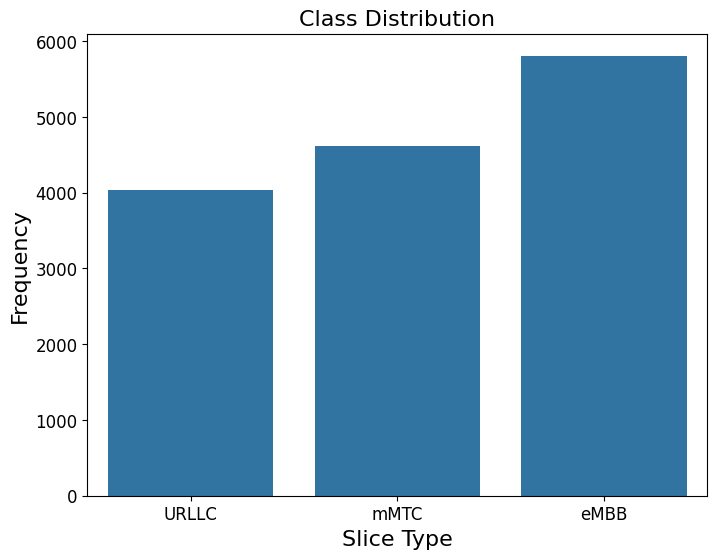

In [10]:
df = data.copy()

# Class Distribution Plot
plt.figure(figsize=(8, 6))
sns.countplot(x='SliceType', data=df)
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Slice Type', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [11]:
X = df.drop('SliceType', axis=1)
y = df['SliceType']
X

,X,Seq,Dur,RunTime,Mean,Sum,Min,Max,Proto,sTos,...,DstRate,State,SrcWin,DstWin,SrcTCPBase,DstTCPBase,TcpRtt,SynAck,AckDat,UniqueID
0,34555.0000,982.000000,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,4,224,...,0.000000,1,64128.000,64256.00000,3904203819,3.704605e+09,0.000000,0.000000,0.000000,144379.000
1,531568.0000,11362.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0,...,0.000000,4,1270506.667,63695.85949,1836252122,2.446250e+09,0.000000,0.000000,0.000000,181691.000
2,360399.0000,70834.000000,2.560251,2.560251,2.560251,2.560251,2.560251,2.560251,4,0,...,0.000000,5,1270506.667,63695.85949,1836252122,2.446250e+09,0.000000,0.000000,0.000000,175580.000
3,30702.0000,440.000000,0.046014,0.046014,0.046014,0.046014,0.046014,0.046014,4,0,...,43.465034,1,56960.000,77568.00000,97975463,3.508802e+09,0.000000,0.000000,0.000000,120239.000
4,312747.0000,128397.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0,...,0.000000,4,1270506.667,63695.85949,1836252122,2.446250e+09,0.000000,0.000000,0.000000,348612.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14451,455292.3772,281.829734,3.620188,3.961441,3.642492,4.080528,3.689328,3.684907,3,0,...,1.594339,1,64256.000,64896.00000,1202036791,1.485176e+08,0.595314,0.723920,0.032170,2373584.832
14452,455262.0258,298.318232,4.376486,2.966175,3.594366,3.873222,3.280655,3.083385,3,0,...,1.400239,1,64256.000,64896.00000,1202036791,1.485176e+08,0.652207,0.874332,0.028468,2367298.319
14453,455286.2470,293.324452,3.818366,3.667252,4.340313,4.514485,3.882577,4.103266,3,0,...,1.626468,1,64256.000,64896.00000,1202036791,1.485176e+08,0.876566,0.250007,0.041358,2383580.426
14454,455211.1026,171.202752,4.414447,4.101491,4.156414,4.301263,4.173065,4.550792,3,0,...,1.408035,1,64256.000,64896.00000,1202036791,1.485176e+08,0.547553,0.645027,0.027258,2384145.715


In [12]:
y

,SliceType
0,URLLC
1,URLLC
2,URLLC
3,URLLC
4,URLLC
...,...
14451,mMTC
14452,mMTC
14453,mMTC
14454,mMTC


#**KMeans + tsne**

In [13]:
# Separate features and target
X = data.drop('SliceType', axis=1)
y = data['SliceType']

# Define the number of clusters
n_clusters = 3

# Apply k-means clustering on the extracted features
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_model.fit(X)

# Get cluster labels
cluster_labels = kmeans_model.labels_

# Evaluate clustering quality with silhouette score
silhouette_avg = silhouette_score(X, cluster_labels)
print(f"Silhouette Score for k-means on raw features: {silhouette_avg}")

# Evaluate clustering quality with Davies-Bouldin Index
db_index_avg = davies_bouldin_score(X, cluster_labels)
print("Davies-Bouldin Index for k-means on raw features: ", db_index_avg)

Silhouette Score for k-means on raw features: 0.4475768705352439
Davies-Bouldin Index for k-means on raw features:  0.9723427336217636


Silhouette Score for k-means: 0.4475768705352439
Davies-Bouldin Index for k-means:  0.9723427336217636


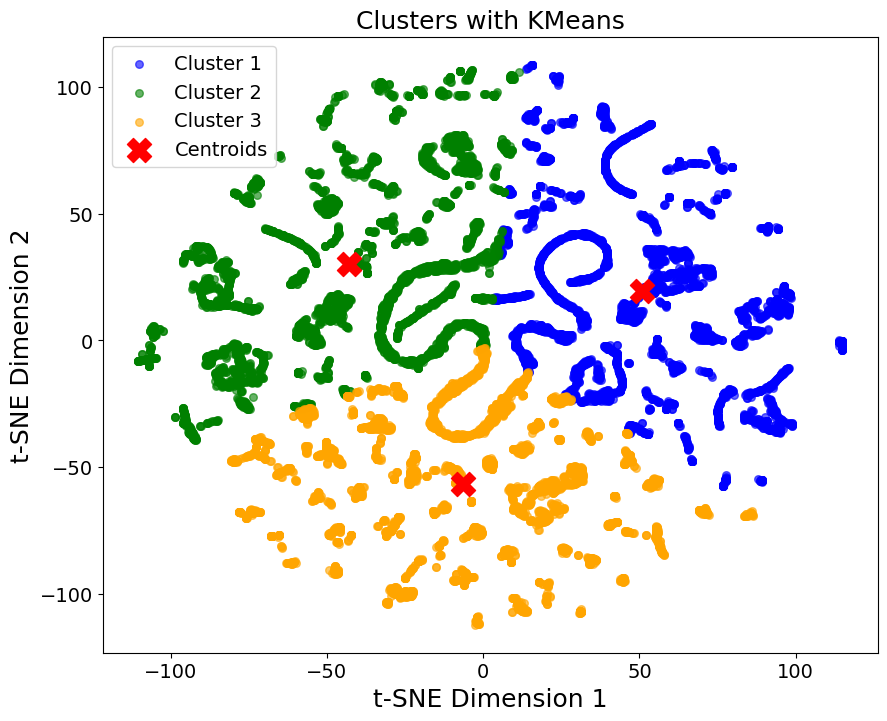

In [17]:
from sklearn.manifold import TSNE

# Separate features and target
X = data.drop('SliceType', axis=1)
y = data['SliceType']

# Define the number of clusters
n_clusters = 3

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42)
X_encoded_2D = tsne.fit_transform(X)

# Fit KMeans on the t-SNE reduced data
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans_model.fit_predict(X_encoded_2D)
centroids = kmeans_model.cluster_centers_

# Evaluate clustering quality with silhouette score
# silhouette_avg = silhouette_score(X, cluster_labels)
print(f"Silhouette Score for k-means: {silhouette_avg}")

# Evaluate clustering quality with Davies-Bouldin Index
# db_index_avg = davies_bouldin_score(X, cluster_labels)
print("Davies-Bouldin Index for k-means: ", db_index_avg)

# Plot the data points and centroids
# Set global font size using rcParams
plt.rcParams.update({
    'font.size': 16,  # Set the base font size for all text
    'axes.titlesize': 18,  # Title font size
    'axes.labelsize': 18,  # X and Y label font size
    'xtick.labelsize': 14,  # X tick label font size
    'ytick.labelsize': 14,  # Y tick label font size
    'legend.fontsize': 14  # Legend font size
})

# Plot the data points and centroids
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange']  # Define colors for clusters
for i in range(n_clusters):
    # Plot the points for each cluster
    plt.scatter(X_encoded_2D[cluster_labels == i, 0], X_encoded_2D[cluster_labels == i, 1],
                s=30, color=colors[i], label=f'Cluster {i+1}', alpha=0.6)

# Plot the centroids (transforming them is optional with t-SNE)
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='X', label='Centroids')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Clusters with KMeans')
plt.legend()
plt.show()

# **5G Slice Ndd Dataset with Standalone Neural Network**
Autoencoders + KMeans

In [18]:
# Load the preprocessed dataset
# data3 = pd.read_csv('/content/drive/MyDrive/Dataset/5G_SliciNdd_preprocessed.csv')
data3 = data

# Separate features and target
X3 = data3.drop('SliceType', axis=1)
y3 = data3['SliceType']

# Encode target labels
le = LabelEncoder()
y3_encoded = le.fit_transform(y3)
y3 = to_categorical(y3_encoded)

########################################
# Scale features
# scaler = StandardScaler()
# X3_scaled = scaler.fit_transform(X3)

scaler = RobustScaler()
X3_scaled = scaler.fit_transform(X3)
########################################

# Convert back to DataFrame for easier handling
X3 = pd.DataFrame(X3_scaled, columns=X3.columns)

# Split the data
# X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=test_size, random_state=42)

###############################################################################################################
# Build the neural network model
input_dim = X3.shape[1]
# output_units = y3.shape[1]
encoding_dim = encoding_dim

model3 = build_autoencoder_model(input_dim, encoding_dim)

###############################################################################################################

# Compile the model with custom metrics
# model3.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', recall, precision, f1_score])
model3.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=metrics)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Create a history object to store training metrics
history3 = History()

# # Evaluate the model
# loss3, accuracy3, recall3, precision3 = model3.evaluate(X3_test, y3_test)
# print(f"Test Accuracy before training: {accuracy3:.4f} - Test Loss: {loss3:.4f} - Test Recall: {recall3:.4f} - Test Precision: {precision3:.4f}")

# start time
start_time_neural_network = time.time()

# Train the model with early stopping and history callbacks
model3.fit(X3, X3, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[early_stopping, history3])

# end time
end_time_neural_network = time.time()

latency_neural_network = end_time_neural_network - start_time_neural_network
print(f"\n Standalone Neural Network --- Latency: {latency_neural_network} seconds - Training Accuracy: {history3.history['accuracy'][-1]:.4f} - Validation Accuracy: {history3.history['val_accuracy'][-1]:.4f} \n")

# # Evaluate the model
# loss3, accuracy3, recall3, precision3 = model3.evaluate(X3_test, y3_test)
# print(f"Test Accuracy after training: {accuracy3:.4f} - Test Loss: {loss3:.4f} - Test Recall: {recall3:.4f} - Test Precision: {precision3:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0179 - loss: 28225.8066 - precision_1: 0.8076 - recall_1: 0.6340 - val_accuracy: 0.0000e+00 - val_loss: -203.0809 - val_precision_1: 0.7798 - val_recall_1: 0.7960
Epoch 2/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0234 - loss: 399604.3438 - precision_1: 0.8121 - recall_1: 0.8237 - val_accuracy: 0.0000e+00 - val_loss: -3782.7332 - val_precision_1: 0.7593 - val_recall_1: 0.8487
Epoch 3/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1098 - loss: 5867911.5000 - precision_1: 0.8014 - recall_1: 0.8584 - val_accuracy: 0.0000e+00 - val_loss: -8380.7891 - val_precision_1: 0.7593 - val_recall_1: 0.8488
Epoch 4/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1131 - loss: 5761564.0000 - precision_1: 0.8012 - recall_1: 0.8584 - val_accuracy: 0.0000e+00 - val_loss: -15436.7480 - val_precision_1: 0.7593 - val_recall_1: 0.8488
Epoch 5/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1144 - lo

In [19]:
# # Retrieve metrics from the history object
# train_acc3 = history3.history['accuracy']
# val_acc3 = history3.history['val_accuracy']

# train_loss3 = history3.history['loss']
# val_loss3 = history3.history['val_loss']

# train_precision3 = history3.history['precision']
# val_precision3 = history3.history['val_precision']

# train_recall3 = history3.history['recall']
# val_recall3 = history3.history['val_recall']

# # train_f13 = history3.history['f1_score']
# # val_f13 = history3.history['val_f1_score']

# # Print metrics for each epoch
# # for epoch in range(len(train_acc3)):
# #     print(f"Epoch {epoch+1}:")
# #     print(f"  Training Accuracy: {train_acc3[epoch]:.4f}, Validation Accuracy: {val_acc3[epoch]:.4f}")
# #     print(f"  Training Loss: {train_loss3[epoch]:.4f}, Validation Loss: {val_loss3[epoch]:.4f}")
# #     print(f"  Training Precision: {train_precision3[epoch]:.4f}, Validation Precision: {val_precision3[epoch]:.4f}")
# #     print(f"  Training Recall: {train_recall3[epoch]:.4f}, Validation Recall: {val_recall3[epoch]:.4f}")
# #     print(f"  Training F1 Score: {train_f13[epoch]:.4f}, Validation F1 Score: {val_f13[epoch]:.4f}")


# # Plot accuracy and loss over epochs
# plt.figure(figsize=(20, 5))
# plt.suptitle('Standalone Neural Network')

# plt.subplot(1, 5, 1)
# plt.plot(train_acc3, label='Training Accuracy')
# plt.plot(val_acc3, label='Validation Accuracy')
# plt.title('Accuracy over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 5, 2)
# plt.plot(train_loss3, label='Training Loss')
# plt.plot(val_loss3, label='Validation Loss')
# plt.title('Loss over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 5, 3)
# plt.plot(train_precision3, label='Training Precision')
# plt.plot(val_precision3, label='Validation Precision')
# plt.title('Precision over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Precision')
# plt.legend()

# plt.subplot(1, 5, 4)
# plt.plot(train_recall3, label='Training Recall')
# plt.plot(val_recall3, label='Validation Recall')
# plt.title('Recall over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Recall')
# plt.legend()

# # plt.subplot(1, 5, 5)
# # plt.plot(train_f13, label='Training F1 Score')
# # plt.plot(val_f13, label='Validation F1 Score')
# # plt.title('F1 Score over Epochs')
# # plt.xlabel('Epochs')
# # plt.ylabel('F1 Score')
# # plt.legend()

# plt.tight_layout()
# plt.show()

In [20]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans

# # Define the number of clusters
# n_clusters = 3

# # Apply PCA to reduce to 2D for visualization
# pca = PCA(n_components=2)
# X3_encoded_2D = pca.fit_transform(X3_encoded_features)  # Encoded features from the autoencoder

# # Fit KMeans on the 2D data
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# cluster_labels = kmeans.fit_predict(X3_encoded_2D)
# centroids = kmeans.cluster_centers_

# # Plot the data points and the centroids
# plt.figure(figsize=(10, 7))
# colors = ['blue', 'green', 'orange']  # Define colors for clusters
# for i in range(n_clusters):
#     # Plot the points for each cluster
#     plt.scatter(X3_encoded_2D[cluster_labels == i, 0], X3_encoded_2D[cluster_labels == i, 1], s=30, color=colors[i], label=f'Cluster {i+1}', alpha=0.6)

# # Plot the centroids
# plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='X', label='Centroids')

# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('Clusters with Centroids in 2D Space (PCA Reduced)')
# plt.legend()
# plt.show()

In [21]:
# Extract the Encoder part (for feature extraction)
encoder = Sequential()
for layer in model3.layers[:3]:  # Copy only encoder layers
    encoder.add(layer)

# Extract learned features (bottleneck representations)
X3_encoded_features = encoder.predict(X3)
print(f"Encoded Features Shape: {X3_encoded_features.shape}")

452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Encoded Features Shape: (14456, 10)


In [22]:
# Define the number of clusters
n_clusters = 3

# Apply k-means clustering on the extracted features
kmeans_model3 = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_model3.fit(X3_encoded_features)

# Get cluster labels
cluster_labels3 = kmeans_model3.labels_

# Evaluate clustering quality with silhouette score
silhouette_avg3 = silhouette_score(X3_encoded_features, cluster_labels3)
print(f"Silhouette Score for Standalone Neural Network: {silhouette_avg3}")

# Evaluate clustering quality with Davies-Bouldin Index
db_index_avg3 = davies_bouldin_score(X3_encoded_features, cluster_labels3)
print("Davies-Bouldin Index for Standalone Neural Network: ", db_index_avg3)

Silhouette Score for Standalone Neural Network: 0.7683786153793335
Davies-Bouldin Index for Standalone Neural Network:  0.3291427154037771


Silhouette Score for Standalone Neural Network: 0.7683786153793335
Davies-Bouldin Index for Standalone Neural Network:  0.3291427154037771


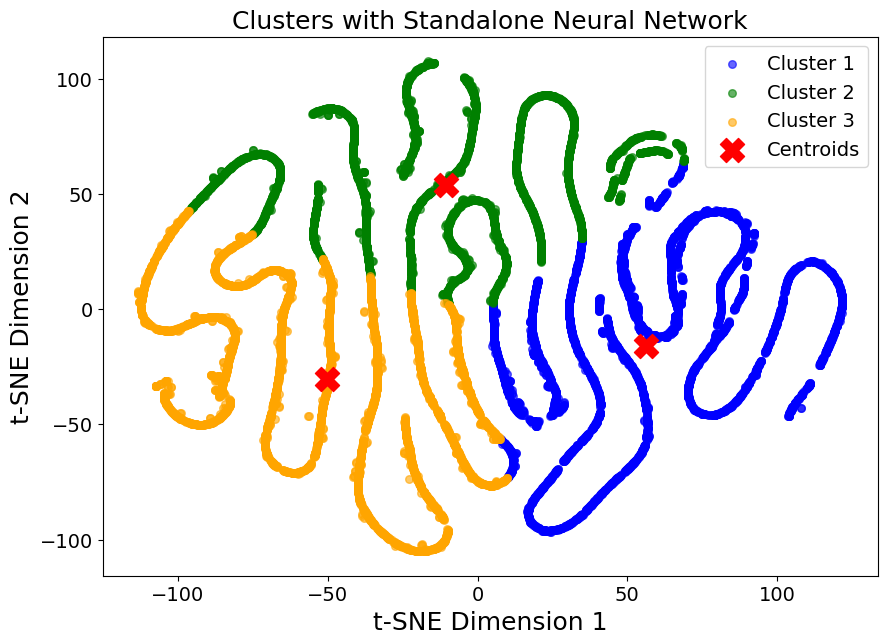

In [23]:
from sklearn.manifold import TSNE

# Define the number of clusters
n_clusters = 3

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42)
X3_encoded_2D = tsne.fit_transform(X3_encoded_features)

# Fit KMeans on the t-SNE reduced data
kmeans_model3 = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels3 = kmeans_model3.fit_predict(X3_encoded_2D)
centroids3 = kmeans_model3.cluster_centers_

# # Evaluate clustering quality with silhouette score
# silhouette_avg = silhouette_score(X3_encoded_features, cluster_labels3)
print(f"Silhouette Score for Standalone Neural Network: {silhouette_avg3}")

# # Evaluate clustering quality with Davies-Bouldin Index
# db_index_avg = davies_bouldin_score(X3_encoded_features, cluster_labels3)
print("Davies-Bouldin Index for Standalone Neural Network: ", db_index_avg3)

# Plot the data points and centroids
# Set global font size using rcParams
plt.rcParams.update({
    'font.size': 16,  # Set the base font size for all text
    'axes.titlesize': 18,  # Title font size
    'axes.labelsize': 18,  # X and Y label font size
    'xtick.labelsize': 14,  # X tick label font size
    'ytick.labelsize': 14,  # Y tick label font size
    'legend.fontsize': 14  # Legend font size
})

plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'orange']  # Define colors for clusters
for i in range(n_clusters):
    # Plot the points for each cluster
    plt.scatter(X3_encoded_2D[cluster_labels3 == i, 0], X3_encoded_2D[cluster_labels3 == i, 1], s=30, color=colors[i], label=f'Cluster {i+1}', alpha=0.6)

# Plot the centroids (transforming them is optional with t-SNE)
plt.scatter(centroids3[:, 0], centroids3[:, 1], s=300, c='red', marker='X', label='Centroids')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
# plt.title('Clusters with Centroids in 2D Space (t-SNE Reduced)')
plt.title('Clusters with Standalone Neural Network')
plt.legend()
plt.show()

In [ ]:
# # Predict on the test set
# y_pred3 = model3.predict(X3_test)

# # Convert predictions to class labels
# y_pred3_class = np.argmax(y_pred3, axis=1)
# y_test_class = np.argmax(y3_test, axis=1)

# # Calculate precision, recall, and F1 score
# precision = precision_score(y_test_class, y_pred3_class, average='macro')
# recall = recall_score(y_test_class, y_pred3_class, average='macro')
# f1 = f1_score(y_test_class, y_pred3_class, average='macro')

# # Calculate confusion matrix
# conf_mat = confusion_matrix(y_test_class, y_pred3_class)

# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")
# print("Confusion Matrix:")
# print(conf_mat)

# **Base Model using Neural Network on DeepSlice Dataset**

In [24]:
# Load deepslice_data.csv
data1 = pd.read_csv('/content/drive/MyDrive/Dataset/deepslice_data.csv.zip')

# Data pre-processing
# Feature Conversion - Categorical to Numerical
one_hot_encoded_data1 = pd.get_dummies(data1, columns = ['Day','Use Case', 'Technology Supported', 'GBR'])
data1_ohe = one_hot_encoded_data1.rename(columns={'Day_sunday':'sunday','Day_monday':'monday','Day_tuesday':'tuesday','Day_wednesday':'wednesday','Day_thrusday':'thrusday','Day_friday':'friday','Day_saturday':'saturday','Use Case_AR/VR/Gaming':'AR/VR/Gaming','Use Case_Healthcare':'Healthcare','Use Case_Industry 4.0':'Industry 4.0','Use Case_IoT Devices':'IoT Devices','Use Case_Public Safety':'Public Safety','Use Case_Smart City & Home':'Smart City & Home','Use Case_Smart Transportation':'Smart Transportation','Use Case_Smartphone':'Smartphone','Technology Supported_IoT(LTE-M, NB-IoT)':'IoT','Technology Supported_LTE/5G':'LTE/5G','GBR_GBR':'GBR','GBR_Non-GBR':'Non-GBR'})
data1 = data1_ohe[['LTE/5g Category', 'Time', 'sunday', 'monday', 'tuesday', 'wednesday', 'thrusday', 'friday', 'saturday', 'Packet Loss Rate', 'Packet delay', 'IoT',	'LTE/5G',	'GBR',	'Non-GBR', 'AR/VR/Gaming',	'Healthcare',	'Industry 4.0', 'IoT Devices',	'Public Safety',	'Smart City & Home',	'Smart Transportation',	'Smartphone', 'slice Type']]

# Replace boolean values with 0 and 1 in specified columns
columns_to_convert = ['sunday', 'monday', 'tuesday', 'wednesday', 'thrusday', 'friday', 'saturday', "IoT", "LTE/5G", "GBR", "Non-GBR", "AR/VR/Gaming", "Healthcare", "Industry 4.0", "IoT Devices", "Public Safety", "Smart City & Home", "Smart Transportation", "Smartphone"]
for column in columns_to_convert:
    data1[column] = data1[column].replace({False: 0, True: 1})

data1 = data1.drop_duplicates()

X1 = data1.drop('slice Type', axis=1)
y1 = data1['slice Type']

# Encode target labels if necessary
le = LabelEncoder()
y1_encoded = le.fit_transform(y1)

# Scale features
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)

# Split data into train and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y1_encoded, test_size=0.2, random_state=42)

##################################################################################################
# Create a new model with input layer
input_dim_X1 = X1_scaled.shape[1]
output_units_y1 = len(np.unique(y1_encoded))

# Build the model for X1_scaled and y1_encoded
model1 = build_NN_model(input_dim=input_dim_X1, output_units=output_units_y1)

#################################################################################################

# Compile the model
model1.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create a history object to store training metrics
history1 = History()

# start time
start_time_base_model1_training = time.time()

# Train the model on new data
model1.fit(X1_train, y1_train, epochs=10, batch_size=32, validation_split=0.5, callbacks=[early_stopping, history1])

# end time
end_time_base_model1_training = time.time()

latency_base_model1_training = end_time_base_model1_training - start_time_base_model1_training
print(f"\n Latency for base model1 training: {latency_base_model1_training} seconds")

# Evaluate on test set
loss1, accuracy1 = model1.evaluate(X1_test, y1_test)
print(f"Test Accuracy: {accuracy1:.4f}")

# Save the trained model if needed
model1.save('deep_slice_model.h5')

<ipython-input-24-b56a8ab1beae>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data1[column] = data1[column].replace({False: 0, True: 1})
<ipython-input-24-b56a8ab1beae>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1[column] = data1[column].replace({False: 0, True: 1})



 Building simple model
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


790/790 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4196 - loss: 1.0720 - val_accuracy: 0.6089 - val_loss: 0.9396
Epoch 2/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5786 - loss: 0.9479 - val_accuracy: 0.7135 - val_loss: 0.8178
Epoch 3/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6849 - loss: 0.8301 - val_accuracy: 0.8654 - val_loss: 0.6857
Epoch 4/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7671 - loss: 0.7101 - val_accuracy: 0.9347 - val_loss: 0.5540
Epoch 5/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8371 - loss: 0.5876 - val_accuracy: 0.9737 - val_loss: 0.4336
Epoch 6/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8938 - loss: 0.4730 - val_accuracy: 0.9971 - val_loss: 0.3302
Epoch 7/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9330 - loss: 0.3786 - val_accuracy: 0.9987 - val_loss: 0.2452
Epoch 8/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9594 - loss: 0.2982 - val_accuracy: 0.9979 - val_

Test Accuracy: 0.9989


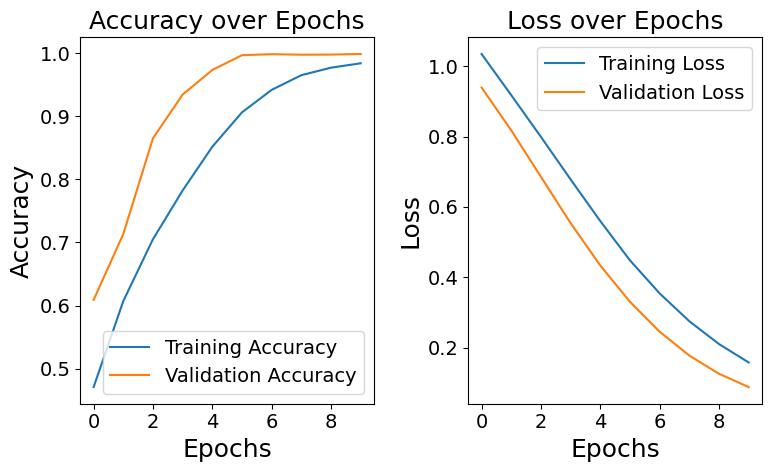

In [25]:
# Retrieve metrics from the history object
train_acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Print metrics for each epoch
# for epoch in range(len(train_acc)):
#     print(f"Epoch {epoch+1}:")
#     print(f"  Training Accuracy: {train_acc[epoch]:.4f}, Validation Accuracy: {val_acc[epoch]:.4f}")
#     print(f"  Training Loss: {train_loss[epoch]:.4f}, Validation Loss: {val_loss[epoch]:.4f}")

# Plot accuracy and loss over epochs
plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **Transfer Learning on 5G Slice Ndd Dataset**

In [26]:
# print(f"Shape of X2_scaled: {X2_scaled.shape}")
# print(f"Input shape of pre-trained model: {model2.input_shape}")

In [27]:
# Load deepslice_data.csv
# data2 = pd.read_csv('/content/drive/MyDrive/Dataset/5G_SliciNdd_preprocessed.csv')
data2 = data

# Data pre-processing
# Separate features and target
X2 = data2.drop('SliceType', axis=1)
y2 = data2['SliceType']

# Encode target labels
le = LabelEncoder()
y2_encoded = le.fit_transform(y2)
y2 = to_categorical(y2_encoded)

# Scale features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

scaler = RobustScaler()
X2_scaled = scaler.fit_transform(X2)

# Convert back to DataFrame for easier handling
X2 = pd.DataFrame(X2_scaled, columns=X2.columns)

##################################################################################################
# Load pre-trained feature extractor model and remove classification layer
base_model = load_model('deep_slice_model.h5')

# Create a new model with the defined input shape
input_layer = Input(shape=(48,))
output_layer = Dense(first_layer_neurons, activation='relu')(input_layer)

for layer in base_model.layers[1:]:
    output_layer = layer(output_layer)
model2 = Model(inputs=input_layer, outputs=output_layer) # Now the model has a defined input

# Use the feature extractor on the unlabelled 5G Slice Ndd data
X2_features = model2.predict(X2_scaled)

#################################################################################################

# # Apply KMeans clustering on extracted features
# kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust n_clusters as needed
# clusters = kmeans.fit_predict(X2_features)

# # Analyze results
# # Optionally, map clusters to slice types for evaluation purposes if known, or analyze with metrics like silhouette score
# print("KMeans Clustering Results on Transfer Learning Features:", clusters)

# # Evaluate with silhouette score or compare cluster distributions to standalone network results
# silhouette_avg = silhouette_score(X2_features, clusters)
# print(f"Silhouette Score: {silhouette_avg}")

# # Evaluate clustering quality with Davies-Bouldin Index
# db_index_avg = davies_bouldin_score(X2_features, clusters)
# print("Davies-Bouldin Index: ", db_index_avg)

452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [28]:
# # Retrieve metrics from the history object
# train_acc2 = history2.history['accuracy']
# val_acc2 = history2.history['val_accuracy']

# train_loss2 = history2.history['loss']
# val_loss2 = history2.history['val_loss']

# train_precision2 = history2.history['precision']
# val_precision2 = history2.history['val_precision']

# train_recall2 = history2.history['recall']
# val_recall2 = history2.history['val_recall']

# # train_f12 = history2.history['f1_score']
# # val_f12 = history2.history['val_f1_score']

# # Print metrics for each epoch
# # for epoch in range(len(train_acc2)):
# #     print(f"Epoch {epoch+1}:")
# #     print(f"  Training Accuracy: {train_acc2[epoch]:.4f}, Validation Accuracy: {val_acc2[epoch]:.4f}")
# #     print(f"  Training Loss: {train_loss2[epoch]:.4f}, Validation Loss: {val_loss2[epoch]:.4f}")
# #     print(f"  Training Precision: {train_precision2[epoch]:.4f}, Validation Precision: {val_precision2[epoch]:.4f}")
# #     print(f"  Training Recall: {train_recall2[epoch]:.4f}, Validation Recall: {val_recall2[epoch]:.4f}")
# #     print(f"  Training F1 Score: {train_f12[epoch]:.4f}, Validation F1 Score: {val_f12[epoch]:.4f}")


# # Plot accuracy and loss over epochs
# plt.figure(figsize=(20, 5))
# plt.suptitle('Transfer Learning')

# plt.subplot(1, 5, 1)
# plt.plot(train_acc2, label='Training Accuracy')
# plt.plot(val_acc2, label='Validation Accuracy')
# plt.title('Accuracy over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 5, 2)
# plt.plot(train_loss2, label='Training Loss')
# plt.plot(val_loss2, label='Validation Loss')
# plt.title('Loss over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 5, 3)
# plt.plot(train_precision2, label='Training Precision')
# plt.plot(val_precision2, label='Validation Precision')
# plt.title('Precision over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Precision')
# plt.legend()

# plt.subplot(1, 5, 4)
# plt.plot(train_recall2, label='Training Recall')
# plt.plot(val_recall2, label='Validation Recall')
# plt.title('Recall over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Recall')
# plt.legend()

# # plt.subplot(1, 5, 5)
# # plt.plot(train_f12, label='Training F1 Score')
# # plt.plot(val_f12, label='Validation F1 Score')
# # plt.title('F1 Score over Epochs')
# # plt.xlabel('Epochs')
# # plt.ylabel('F1 Score')
# # plt.legend()

# plt.tight_layout()
# plt.show()

In [29]:
# Extract the Encoder part (for feature extraction)
encoder = Sequential()
for layer in model2.layers[:3]:  # Copy only encoder layers
    encoder.add(layer)

# Extract learned features (bottleneck representations)
X2_encoded_features = encoder.predict(X2)
print(f"Encoded Features Shape: {X2_encoded_features.shape}")

452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Encoded Features Shape: (14456, 64)


In [30]:
# Define the number of clusters
n_clusters = 3

# Apply k-means clustering on the extracted features
kmeans_model2 = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_model2.fit(X2_encoded_features)

# Get cluster labels
cluster_labels2 = kmeans_model2.labels_

# Evaluate clustering quality with silhouette score
silhouette_avg2 = silhouette_score(X2_encoded_features, cluster_labels2)
print(f"Silhouette Score for Transfer Learning: {silhouette_avg2}")

# Evaluate clustering quality with Davies-Bouldin Index
db_index_avg2 = davies_bouldin_score(X3_encoded_features, cluster_labels2)
print("Davies-Bouldin Index for Transfer Learning: ", db_index_avg2)

Silhouette Score for Transfer Learning: 0.9987437129020691
Davies-Bouldin Index for Transfer Learning:  0.004618049664327011


Silhouette Score for Transfer Learning: 0.9987437129020691
Davies-Bouldin Index for Transfer Learning:  0.004618049664327011


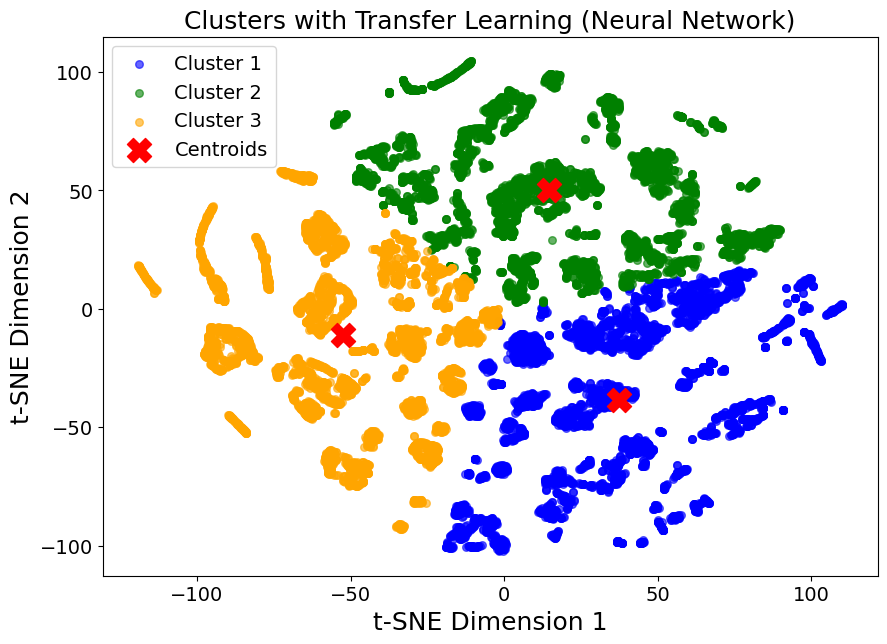

In [31]:
from sklearn.manifold import TSNE

# Define the number of clusters
n_clusters = 3

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42)
X2_encoded_2D = tsne.fit_transform(X2_encoded_features)

# Fit KMeans on the t-SNE reduced data
kmeans_model2 = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels2 = kmeans_model2.fit_predict(X2_encoded_2D)
centroids2 = kmeans_model2.cluster_centers_

# # Evaluate clustering quality with silhouette score
# silhouette_avg = silhouette_score(X2_encoded_features, cluster_labels2)
print(f"Silhouette Score for Transfer Learning: {silhouette_avg2}")

# # Evaluate clustering quality with Davies-Bouldin Index
# db_index_avg = davies_bouldin_score(X2_encoded_features, cluster_labels2)
print("Davies-Bouldin Index for Transfer Learning: ", db_index_avg2)

# Plot the data points and centroids
# Set global font size using rcParams
plt.rcParams.update({
    'font.size': 16,  # Set the base font size for all text
    'axes.titlesize': 18,  # Title font size
    'axes.labelsize': 18,  # X and Y label font size
    'xtick.labelsize': 14,  # X tick label font size
    'ytick.labelsize': 14,  # Y tick label font size
    'legend.fontsize': 14  # Legend font size
})

plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'orange']  # Define colors for clusters
for i in range(n_clusters):
    # Plot the points for each cluster
    plt.scatter(X2_encoded_2D[cluster_labels2 == i, 0], X2_encoded_2D[cluster_labels2 == i, 1], s=30, color=colors[i], label=f'Cluster {i+1}', alpha=0.6)

# Plot the centroids (transforming them is optional with t-SNE)
plt.scatter(centroids2[:, 0], centroids2[:, 1], s=300, c='red', marker='X', label='Centroids')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
# plt.title('Clusters with Centroids in 2D Space (t-SNE Reduced)')
plt.title('Clusters with Transfer Learning (Neural Network)')
plt.legend()
plt.show()

# **SYNC NOTEBOOKS**

In [ ]:
%cp '/content/drive/MyDrive/Colab Notebooks/Exp20_NSI_UnSup_TL_autoencoders.ipynb' '/content/drive/MyDrive/Network_Slicing_with_ML_repo/Network-Slicing-with-ML/Notebooks/'